In [26]:
import psycopg2
conn = psycopg2.connect("dbname=testdb user=abarciauskas")
cur = conn.cursor()

cur.execute("SELECT Score FROM alignments ORDER BY random() LIMIT 20000;")
scores = cur.fetchall()
cur.close()
conn.close()

In [27]:
score_list = [score[0] for score in scores]

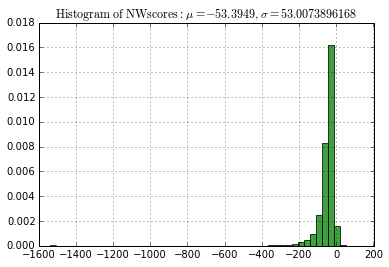

In [28]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(score_list, 50, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(score_list)
sigma = np.std(score_list)
plt.title(r'$\mathrm{Histogram\ of\ NW scores:}\ \mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')

plt.grid(True)

plt.show()